# Classification model for EBOV VP40

## Main Project

### Functions emplopyed in the project

In [6]:
def graphing(a):
    # Creating dataset
    label = ['Actives', 'Inactives']
    
    data = a
    # Creating explode data
    explode = (0.2, 0.0)
    
    # Creating color parameters
    colors = ( "blue","orange")
    
    # Wedge properties
    wp = { 'linewidth' : 1, 'edgecolor' : "green" }
    
    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)
    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 6))
    wedges, texts, autotexts = ax.pie(data, 
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode, 
                                  labels = label,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
    # Adding legend
    ax.legend(wedges, label,
          title ="Datasets",
          loc ="upper left",
          bbox_to_anchor =(1, 0, 0.5, 1))
    
    plt.setp(autotexts, size = 10, weight ="bold")
    ax.set_title("Pie Chart of Data Distibution")
    # show plot
    plt.show()
    


In [7]:
def mannwhitney(descriptor, verbose=False):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu
    
    #seed the random number generator
    seed(1)
    
    #actives and inactives
    selection = [descriptor, 'Label']
    df = Data[selection]
    active = df[df.Label==1]
    active = active[descriptor]
    
    selection = [descriptor, 'Label']
    df = Data[selection]
    inactive = df[df.Label==0]
    inactive = inactive[descriptor]
    
    #compare samples
    stat, p =mannwhitneyu(active, inactive)
    #print('Stastistics=%.3f, p=%.3f' % (stat,p))
    
    #Interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution'
    else:
        interpretation = 'Different distribution'
    results =pd.DataFrame({'Descriptor':descriptor,
                           'Statistics':stat,
                           'p':p,
                           'alpha':alpha,
                           'Interpretation':interpretation}, index=[0])
    
    #filename = 'mannwhitneyu_results.csv'
    #filename = 'mannwhitneyu_' + descriptor + '.csv'
    #results.to_csv(filename)
    
    return results

### Importing Datasets and libraries 

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter.filedialog import asksaveasfilename as sa

from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
import sklearn
import imblearn
im = imblearn.__version__
sk = sklearn.__version__
pp = pd.__version__
nn = np.__version__
print('sklearn ',sk)
print('imblearn',im)
print('pandas',pp)
print('numpy',nn)

sklearn  0.24.2
imblearn 0.9.0
pandas 1.4.2
numpy 1.21.6


In [2]:
#Importing actives and inactive files followed by labelling the datasets
act = pd.read_csv('actives.csv')
inact = pd.read_csv('inactives.csv')
m=np.ones((act.shape[0],1))
n=np.zeros((inact.shape[0],1))
q = np.concatenate((m,n),axis=0)

In [3]:
#Merging active and inactive datasets and adding string labels
Data = pd.concat([act,inact],axis=0)
#Data = Data.drop(['Name'],axis=1)
lc = [];
for i in q:
    if i ==1:
        lc.append('Active')
    else:
        lc.append('Inactive')
Data['Label']=lc
Data

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Label
0,135565635,0,-1.5652,2.449851,28.1800,46.230688,18,21,39,23,...,47.593070,2.069264,21.060562,2.544035,18.516527,1108.0,39.0,1.354,130.0,Active
1,135474890,0,1.3415,1.799622,73.4343,56.709411,6,6,51,24,...,47.569611,1.982067,10.990267,8.016265,2.974002,1346.0,40.0,5.874,120.0,Active
2,135409453,0,-2.0012,4.004801,48.5254,49.798239,9,10,45,22,...,44.185231,2.008420,17.434467,2.798494,14.635974,1306.0,28.0,3.939,104.0,Active
3,135398737,0,0.0092,0.000085,45.0577,50.929067,12,12,42,23,...,48.038579,2.088634,15.681640,0.000000,13.131199,1082.0,41.0,4.323,126.0,Active
4,73265192,0,-3.1232,9.754378,128.9089,88.960927,6,6,81,42,...,83.725615,1.993467,34.948217,20.472254,14.475964,5641.0,88.0,0.603,234.0,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,460,0,-0.5121,0.262246,9.8804,19.258344,6,6,17,9,...,17.548927,1.949881,5.273677,5.273677,0.000000,86.0,10.0,1.389,40.0,Inactive
1373,403,0,-1.2102,1.464584,6.7867,17.129551,6,6,15,8,...,15.532829,1.941604,4.990326,2.495163,2.495163,62.0,7.0,0.803,36.0,Inactive
1374,323,0,0.3378,0.114109,11.6864,21.444758,6,6,17,11,...,22.509724,2.046339,5.588995,5.588995,0.000000,144.0,14.0,3.230,56.0,Inactive
1375,227,1,-0.9897,0.979506,11.4414,19.691551,6,6,17,10,...,19.384819,1.938482,7.332074,4.814127,2.517947,114.0,12.0,1.643,46.0,Inactive


### Splitting Data before preprocessing

In [4]:
num1 = np.array(Data)
np.random.seed(42)
np.take(num1,np.random.permutation(num1.shape[0]),axis=0,out=num1)
g=num1.shape[0]
r=int(0.75*g)
test=num1[r:g,:]
train=num1[0:r,:]
colo = Data.columns
Datum = pd.DataFrame(test,columns=colo)
Datum = Datum.drop_duplicates(subset='Name',keep='first')
Datum=Datum.reset_index()
Datum.drop('index',axis=1,inplace=True)

Datt = pd.DataFrame(train,columns=colo)
Datt = Datt.drop_duplicates(subset='Name',keep='first')
Datt=Datt.reset_index()
Datt.drop('index',axis=1,inplace=True)

In [8]:
Datum

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Label
0,71203,0,-0.6469,0.41848,52.9108,51.111446,9,10,44,22,...,46.878142,2.130825,9.793565,2.60861,7.184955,837.0,48.0,3.601,134.0,Active
1,7314,1,-4.5849,21.021308,70.6843,45.413446,0,0,46,24,...,46.274088,1.928087,30.842538,30.842538,0.0,1297.0,41.0,-4.847,116.0,Inactive
2,3440,1,-0.9949,0.989826,33.6078,39.744723,11,11,32,21,...,41.518231,1.977059,23.920584,12.627385,5.477541,939.0,30.0,0.884,108.0,Inactive
3,8814,0,2.4663,6.082636,39.9171,40.111446,6,6,37,15,...,28.746749,1.91645,2.513665,2.513665,0.0,366.0,19.0,6.302,76.0,Active
4,138395,0,1.1838,1.401382,11.3481,26.214344,10,11,20,12,...,24.360548,2.030046,5.589479,0.0,3.051963,185.0,16.0,3.41,62.0,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,78212,0,2.1361,4.562923,29.6606,32.604758,11,12,23,17,...,33.79622,1.988013,16.015231,5.432717,3.063108,470.0,27.0,3.509,88.0,Inactive
491,71616,0,0.8521,0.726074,23.6306,45.468102,17,17,39,25,...,50.334469,2.013379,25.560543,2.584059,15.378807,1359.0,41.0,2.193,132.0,Inactive
492,37384,0,-1.6657,2.774556,49.4379,57.413032,12,12,51,27,...,54.039052,2.001446,19.865308,13.958917,5.90639,2688.0,32.0,2.796,126.0,Inactive
493,10982,0,-0.4965,0.246512,38.0615,27.849067,0,0,28,9,...,16.4983,1.833144,2.374997,0.0,2.374997,108.0,6.0,2.89,34.0,Inactive


In [9]:
Datt

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Label
0,2767,0,1.0674,1.139343,12.2044,10.86,0,0,3,3,...,4.914214,1.638071,6.828427,0.0,0.0,4.0,0.0,1.161,6.0,Active
1,985,1,-3.8977,15.192065,55.518,51.101376,0,0,50,18,...,34.661557,1.925642,4.764159,4.764159,0.0,954.0,15.0,7.57,68.0,Inactive
2,54585,2,-1.5283,2.335701,33.7061,48.033895,12,12,41,26,...,51.707169,1.988737,23.869999,14.686119,9.183879,2087.0,36.0,3.502,126.0,Inactive
3,78766,0,-0.7281,0.53013,30.5813,28.918344,0,0,23,15,...,30.221759,2.014784,14.025324,5.136896,6.449573,342.0,24.0,1.349,76.0,Inactive
4,441242,2,-3.2088,10.296397,79.604,63.920274,11,11,54,36,...,72.549091,2.015253,45.267748,23.384465,18.79526,4114.0,62.0,-1.693,194.0,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,60870,0,0.568,0.322624,50.0644,62.12386,17,18,50,30,...,61.392803,2.046427,19.790534,10.683573,6.087491,2999.0,43.0,5.373,158.0,Inactive
1476,190,0,-1.1703,1.369602,7.5221,17.633965,9,10,15,10,...,20.41041,2.041041,14.696329,0.0,14.696329,105.0,12.0,-0.664,52.0,Inactive
1477,73265192,0,-3.1232,9.754378,128.9089,88.960927,6,6,81,42,...,83.725615,1.993467,34.948217,20.472254,14.475964,5641.0,88.0,0.603,234.0,Active
1478,137264,0,1.1976,1.434246,28.9627,30.934516,6,6,28,16,...,30.850686,1.928168,12.624955,2.479589,3.005738,457.0,21.0,3.702,78.0,Inactive


#### Gathering smiles of compounds used as training data

##### Merging actives and inactives smiles

In [58]:
asmile = pd.read_csv('actives.smi',header=None,delimiter='\t')
inasmile = pd.read_csv('Inactive.smi',header=None,delimiter='\t')
Merged_sm = pd.concat([asmile,inasmile])
Merged_smi = pd.DataFrame(np.array(Merged_sm[0]),columns=['Smiles'])
Merged_smi['IDs']=np.array(Merged_sm[1])                     
Merged_smi = Merged_smi.drop_duplicates(subset='IDs',keep='first')
Merged_smi=Merged_smi.reset_index()
Merged_smi.drop('index',axis=1,inplace=True)
Merged_smi


,Smiles,IDs
0,Oc1cc2c([nH]c(c3nn(C(C)C)c4ncnc(N)c34)c2)cc1,135565635
1,OC1=C(C(=O)CC(C1)c1c(cc(cc1C)C)C)C(=NOCC)CC,135474890
2,O(c1cc2c([nH]cc2/C=N/N/C(=N/CCCCC)/N)cc1)C,135409453
3,Clc1cc2N=C(N3CCN(CC3)C)c3c(Nc2cc1)cccc3,135398737
4,O[C@@]12[C@@H](C[C@@H]3C(=C(O)c4c(C3)c(N(C)C)c...,73265192
...,...,...
1964,O(c1c(O)cccc1)C,460
1965,Oc1ccc(N)cc1,403
1966,o1c2c(cccc2)ccc1=O,323
1967,OC(=O)c1c(N)cccc1,227


##### Getting the test compounds

In [59]:
#test
smiles = []
ids = []
for i in range(len(Datum)):
    for j in range(len(Merged_smi)):
        if Datum['Name'][i] == Merged_smi['IDs'][j]:
            smiles.append(Merged_smi['Smiles'][j])
            ids.append(Merged_smi['IDs'][j])
Test_smi=pd.DataFrame(np.array(smiles),columns=['Smiles'])
Test_smi['IDs']=np.array(ids)
Test_smi = Test_smi.drop_duplicates(subset='IDs',keep='first')
Test_smi=Test_smi.reset_index()
Test_smi.drop('index',axis=1,inplace=True)
Test_smi.to_csv('Test.smi', sep='\t', index=False, header=False)
Test_smi['Labels']=np.array(Datum['Label'])
Test_smi

,Smiles,IDs,Labels
0,O=C1n2c3[C@H]4N(CCC[C@]4(C1)CC)CCc3c1c2cccc1,71203,Active
1,O1[C@@H](O[C@@H]([C@H](O)[C@@H](O)C(=O)O)[C@H]...,7314,Inactive
2,Clc1c(S(=O)(=O)N)cc(c(NCc2occc2)c1)C(=O)O,3440,Inactive
3,Oc1ccc(C(CC(C)(C)C)(C)C)cc1,8814,Active
4,Clc1cc2nc(ccc2cc1)C,138395,Inactive
...,...,...,...
490,Clc1c(c2noc(c2C(=O)Cl)C)c(Cl)ccc1,78212,Inactive
491,Fc1c([C@](O)([C@@H](C)c2ncncc2F)Cn2ncnc2)ccc(F)c1,71616,Inactive
492,O(CCOc1ccc(NC(=O)C)cc1)CCOc1ccc(NC(=O)C)cc1,37384,Inactive
493,NC(CCCC(C)C)C,10982,Inactive


##### Getting the training compounds

In [60]:
#train
smiles = []
ids = []
for i in range(len(Datt)):
    for j in range(len(Merged_smi)):
        if Datt['Name'][i] == Merged_smi['IDs'][j]:
            smiles.append(Merged_smi['Smiles'][j])
            ids.append(Merged_smi['IDs'][j])
Train_smi=pd.DataFrame(np.array(smiles),columns=['Smiles'])
Train_smi['IDs']=np.array(ids)
Train_smi = Train_smi.drop_duplicates(subset='IDs',keep='first')
Train_smi=Train_smi.reset_index()
Train_smi.drop('index',axis=1,inplace=True)
Train_smi.to_csv('Train.smi', sep='\t', index=False, header=False)
Train_smi['Labels']=np.array(Datt['Label'])
Train_smi 

,Smiles,IDs,Labels
0,[Pt+2](Cl)Cl.[NH2-].[NH2-],2767,Active
1,OC(=O)CCCCCCCCCCCCCCC,985,Inactive
2,O=C(NCCC(=O)O)c1ccc(/N=N/c2cc(c(O)cc2)C(=O)O)cc1,54585,Inactive
3,ClCCn1c(=O)c2c([nH]c1=O)cccc2,78766,Inactive
4,S(CC1=C(N2[C@H](OC1)[C@](OC)(NC(=O)C(c1ccc(O)c...,441242,Inactive
...,...,...,...
1475,S1C(Cc2ccc(C(=O)CCc3nc(oc3C)c3ccccc3)cc2)C(=O)...,60870,Inactive
1476,[nH]1c2c(nc1)ncnc2N,190,Inactive
1477,O[C@@]12[C@@H](C[C@@H]3C(=C(O)c4c(C3)c(N(C)C)c...,73265192,Active
1478,FC(F)(F)c1cc(NC(=O)C(C)C)ccc1,137264,Inactive


In [19]:
Train_smi.to_csv('Train_smi.csv',index=False)
Test_smi.to_csv('Test_smi.csv',index=False)

### Data Processing And Visualization

#### Dealing with imbalanced data

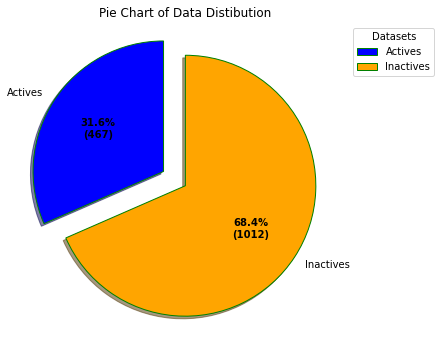

In [43]:
#Datt.drop('Name',axis=1,inplace=True)
#Datum.drop('Name',axis=1,inplace=True)
aaa=0
iii=0
for i in Datt.Label:
    if i =='Active':
        aaa+=1
    else:
        iii+=1
Data = Datt
y=Data.Label
# Show pie plot 
y_p = [aaa,iii]
graphing(y_p)

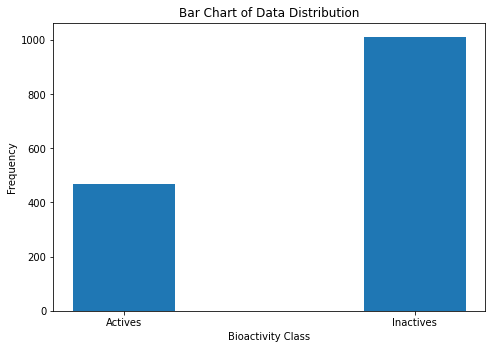

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Actives', 'Inactives']
students = [aaa,iii]
ax.bar(langs,students, width = 0.35)
plt.xlabel('Bioactivity Class')
plt.ylabel('Frequency')
plt.title('Bar Chart of Data Distribution')
plt.show()
plt.savefig('Data.png')

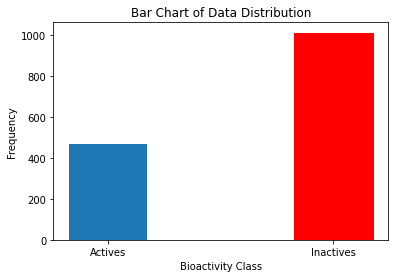

In [25]:
barlist=plt.bar(langs,students, width = 0.35)
barlist[1].set_color('r')
plt.xlabel('Bioactivity Class')
plt.ylabel('Frequency')
plt.title('Bar Chart of Data Distribution')
plt.show()

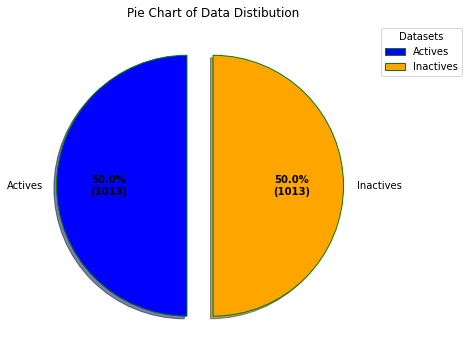

In [50]:
#Random OverSampling
#ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_res, y_res = ros.fit_resample(Data, y)

xx=np.array(y_res)
ab=[]
inab=[]
for i in xx:
    if i == 'Active':
        ab.append(1)
    else:
        inab.append(0)                
y_p = [len(ab),len(inab)]
graphing(y_p)

##### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
Datas= Data.drop('Label',axis=1)
Datas=Datas.fillna(0)

l=[]
for i in y:
    if i == 'Active':
        l.append(1)
    else:
        l.append(0)


Datas.drop('Name',axis=1,inplace=True)


Xs, ys = oversample.fit_resample(Datas, l)

#### Loading From standardized and feature ranked data

In [37]:
#Loading sets of features that works best with padel
dp = pd.read_csv('metrics.csv')
dp.drop('metrics',axis=1,inplace=True)
Data = X_res
Data = Data[dp.columns]


l=[]
for i in y_res:
    if i == 'Active':
        l.append(1)
    else:
        l.append(0)

col = dp.columns
df = pd.DataFrame()
for i in col:
    array = np.array(Data[i])
    mean = dp[i][0]
    std = dp[i][1]
    aa=[]
    #print(aa)
    for j in array:
        n = ((j-mean)/std)
        aa.append(n)
        
        
    df[i]=aa
df['Label'] =l 
df

C:\Users\joe1a\AppData\Local\Temp\ipykernel_13276\954237102.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i]=aa
C:\Users\joe1a\AppData\Local\Temp\ipykernel_13276\954237102.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i]=aa
C:\Users\joe1a\AppData\Local\Temp\ipykernel_13276\954237102.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

,nAcid,ALogP,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nC,...,AMW,WTPT-1,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Label
0,-0.300625,0.905426,-1.306585,-1.973287,-1.594864,-1.559464,-2.220501,-2.200917,-2.013158,-2.403809,...,18.982760,-2.217572,-0.880651,-1.044961,-1.137795,-0.028039,-1.904791,-0.843516,-2.186966,1
1,1.706171,-2.115306,0.178661,0.027919,-1.594864,-1.559464,0.337823,-0.525167,1.041011,-0.179383,...,-0.660080,-0.602939,-1.098154,-0.347660,-1.137795,-0.028038,-1.099560,1.466310,-0.959923,0
2,3.712967,-0.673779,-0.569281,-0.124627,0.550471,0.484901,-0.152069,0.368566,-0.581517,-0.040356,...,0.186519,0.322267,0.914948,1.104558,0.643287,-0.028037,0.027764,0.000189,0.187956,0
3,-0.300625,-0.186943,-0.676432,-1.075244,-1.594864,-1.559464,-1.131852,-0.860317,-1.249616,-1.013542,...,0.419653,-0.843923,-0.122344,-0.293104,0.113008,-0.028038,-0.616421,-0.775760,-0.801595,0
4,3.712967,-1.696184,1.004583,0.665403,0.371693,0.314537,0.555553,1.485733,-0.295188,0.376724,...,0.395407,1.453531,3.169539,2.377682,2.507277,-0.028035,1.423498,-1.872108,1.533746,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,-0.300625,-0.588178,-0.896502,-0.844639,-0.522197,-0.537282,-0.750825,-1.083751,-0.390631,-0.735489,...,-0.491682,-1.054126,-1.330641,-1.044961,-0.641769,-0.028038,-0.938513,0.238776,-0.999505,1
2022,-0.300625,-2.151748,0.738625,0.798776,0.550471,0.484901,0.882148,1.038866,0.659240,0.654777,...,-0.121979,1.025829,1.274557,1.178689,1.206956,-0.028036,1.047723,-2.042578,0.860851,1
2023,-0.300625,1.250811,0.055002,0.044891,0.371693,0.314537,-0.097636,-0.190017,-0.008860,0.237697,...,-0.210827,-0.090911,-0.933846,-1.044961,-0.512473,-0.028038,0.081446,0.601342,-0.009954,1
2024,-0.300625,0.665537,-0.366740,0.030380,0.550471,0.484901,0.065661,0.256850,-0.104303,0.237697,...,-0.027547,0.213989,0.050785,-0.234218,-0.558291,-0.028037,-0.133282,1.343773,0.108792,1


### Training ML Algorithm

#### Model optimization and grid search

##### KNN Optimization

In [18]:
#Select features and labels
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#Training Algorithm  
MOD = [KNeighborsClassifier(n_neighbors=3),KNeighborsClassifier(n_neighbors=5),KNeighborsClassifier(n_neighbors=7)]
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
models=[]
models.append(('KNN3', KNeighborsClassifier(n_neighbors=3)))
models.append(('KNN5',KNeighborsClassifier(n_neighbors=5)))
models.append(('KNN7',KNeighborsClassifier(n_neighbors=7)))
ACC=[]
results=[]
names=[]
scoring='accuracy'
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv = kfold)
    m=cv_results.mean()
    results.append(cv_results)
    names.append(name)
    ACC.append(m)
d= pd.DataFrame(MOD,columns=['Algorithm']);
d['Accuracy']=ACC
d

,Algorithm,Accuracy
0,KNeighborsClassifier(n_neighbors=3),0.802550
1,KNeighborsClassifier(),0.780940
2,KNeighborsClassifier(n_neighbors=7),0.785362


##### SVM Optimization

In [20]:
#Select features and labels
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

from sklearn.model_selection import GridSearchCV
C = [0.1,0.5,2]
gamma = [0.1,0.3,0.5,1]
kernel=['rbf','linear']
hyper = {'kernel':kernel, 'C':C,'gamma':gamma}
gd = GridSearchCV(estimator=SVC(),param_grid=hyper,verbose=True)
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.9150708194825843
SVC(C=2, gamma=0.1)


##### RF Optimization

In [22]:
#Select features and labels
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

from sklearn.model_selection import GridSearchCV

hyper = {'n_estimators':[60,80,120],'max_depth':[6,8]}
gd = GridSearchCV(estimator=RandomForestClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)
gd.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.8865455027219733
RandomForestClassifier(max_depth=8, n_estimators=80)


{'max_depth': 8, 'n_estimators': 80}

##### LR Optimization was set to default

#### Model training

##### 10-fold cross validation

In [56]:
#Select features and labels
ch = pd.read_csv('Check.csv')
df = ch.iloc[:,1:]
df=df.fillna(0)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#Training Algorithm  
MOD = [KNeighborsClassifier(n_neighbors=3),GaussianNB(),SVC(),RandomForestClassifier(max_depth=8, n_estimators=120),LogisticRegression()]
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
models=[]
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier(max_depth=8, n_estimators=120)))
models.append(('LR',LogisticRegression()))
ACC=[]
results=[]
names=[]
scoring='accuracy'
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv = kfold, scoring="precision")
    m=cv_results.mean()
    results.append(cv_results)
    names.append(name)
    ACC.append(m)
d= pd.DataFrame(MOD,columns=['Algorithm']);
d['Precision']=ACC
d

C:\Users\joe1a\anaconda3\envs\joe8\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\joe1a\anaconda3\envs\joe8\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

,Algorithm,Precision
0,KNeighborsClassifier(n_neighbors=3),0.766908
1,GaussianNB(),0.597744
2,SVC(),0.835476
3,"RandomForestClassifier(max_depth=8, n_estimato...",0.874033
4,LogisticRegression(),0.828464


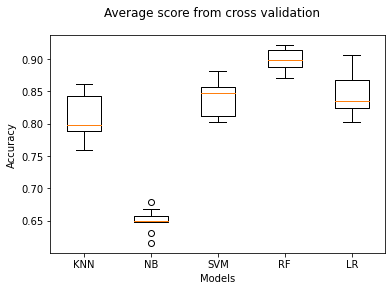

In [53]:
#Graphical Comparism
from matplotlib import pyplot
fig = pyplot.figure()
fig.suptitle('Average score from cross validation')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
pyplot.show()

##### Functions to display results and roc plots

In [41]:
def metricsshow(model):
    y1_predtrain = model.predict(X_train)
    y1_predtest = model.predict(X_test)
    print(model)
    DTACC = metrics.accuracy_score(y_train, y1_predtrain)
    DTPre = metrics.precision_score(y_train, y1_predtrain)
    DTRec = metrics.recall_score(y_train, y1_predtrain)
    DTf1 = metrics.f1_score(y_train, y1_predtrain)
    BA = metrics.balanced_accuracy_score(y_train, y1_predtrain)
    
    
    DTACCt = metrics.accuracy_score(y_test, y1_predtest)
    DTPret = metrics.precision_score(y_test, y1_predtest)
    DTRect = metrics.recall_score(y_test, y1_predtest)
    DTf1t = metrics.f1_score(y_test, y1_predtest)
    BAt = metrics.balanced_accuracy_score(y_test, y1_predtest)
   
    metric = ['Accuracy','Precision','Recall','F1_Score','Bal_Accuracy']
    train = [DTACC, DTPre, DTRec, DTf1, BA]
    test = [DTACCt, DTPret, DTRect, DTf1t, BAt]
    dtt = pd.DataFrame(metric,columns=['Metrics'])
    dtt['Train']=np.array(train)
    dtt['Test'] =np.array(test)
    
    print(dtt)
    

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def showroc(model,title):
    pred_proba=model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_proba[:,1], pos_label =1)
    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # auc scores
    auc_score1 = roc_auc_score(y_test, pred_proba[:,1])
    
    # matplotlib
    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='ROC curve (area = %0.2f)'%auc_score1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='lower right')
    plt.savefig('ROC',dpi=300)
    plt.show();

##### Random Forest Trainer

RandomForestClassifier(max_depth=8, n_estimators=120)
        Metrics     Train      Test
0      Accuracy  0.987306  0.883224
1     Precision  0.983146  0.868750
2        Recall  0.991501  0.905537
3      F1_Score  0.987306  0.886762
4  Bal_Accuracy  0.987324  0.883001


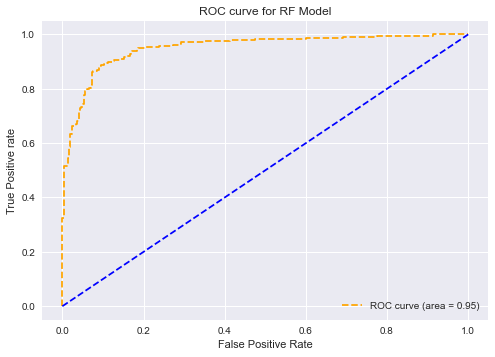

In [44]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
JOEDT = RandomForestClassifier(max_depth=8, n_estimators=120)
JOEDT.fit(X_train, y_train)


metricsshow(JOEDT)
showroc(model=JOEDT,title='ROC curve for RF Model')


##### KNN Trainer

KNeighborsClassifier(n_neighbors=3)
        Metrics     Train      Test
0      Accuracy  0.901269  0.782895
1     Precision  0.858228  0.743733
2        Recall  0.960340  0.869707
3      F1_Score  0.906417  0.801802
4  Bal_Accuracy  0.901518  0.782029


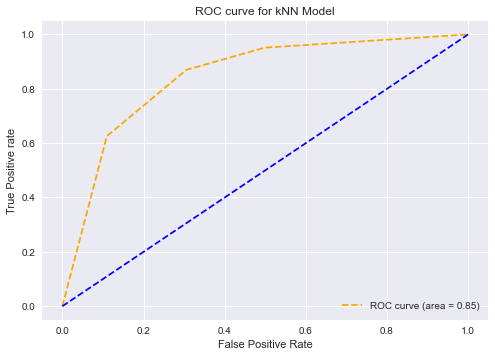

In [45]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
JOEKN=KNeighborsClassifier(n_neighbors=3)
JOEKN.fit(X_train, y_train)

metricsshow(JOEKN)
showroc(model=JOEKN,title='ROC curve for kNN Model')


##### SVM Trainer

SVC(C=2, gamma=0.1, probability=True)
        Metrics     Train      Test
0      Accuracy  0.999295  0.883224
1     Precision  0.998586  1.000000
2        Recall  1.000000  0.768730
3      F1_Score  0.999292  0.869245
4  Bal_Accuracy  0.999298  0.884365


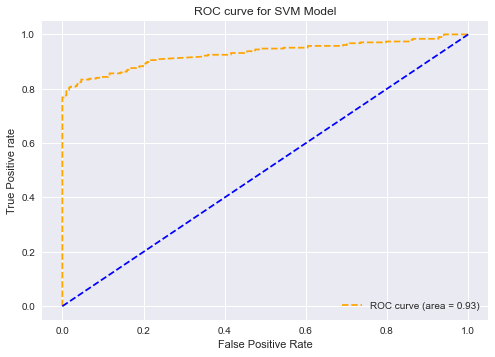

In [46]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
JOESVM=SVC(C=2,gamma=0.1,probability=True)
JOESVM.fit(X_train, y_train)


metricsshow(JOESVM)
showroc(model=JOESVM,title='ROC curve for SVM Model')

##### LR Trainer

C:\Users\joe1a\anaconda3\envs\joe8\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
        Metrics     Train      Test
0      Accuracy  0.937236  0.828947
1     Precision  0.922025  0.802985
2        Recall  0.954674  0.876221
3      F1_Score  0.938065  0.838006
4  Bal_Accuracy  0.937309  0.828476


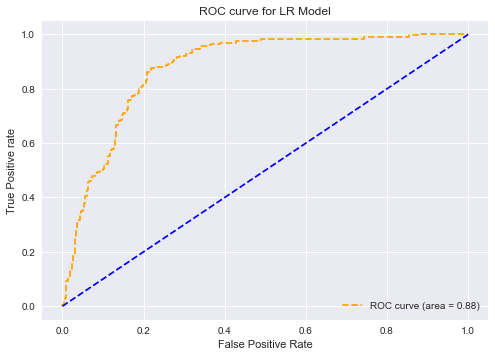

In [47]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
JOELR=LogisticRegression()
JOELR.fit(X_train, y_train)


metricsshow(JOELR)
showroc(model=JOELR,title='ROC curve for LR Model')

##### NB Trainer

GaussianNB()
        Metrics     Train      Test
0      Accuracy  0.669252  0.644737
1     Precision  0.610644  0.596603
2        Recall  0.926346  0.915309
3      F1_Score  0.736072  0.722365
4  Bal_Accuracy  0.670336  0.642040


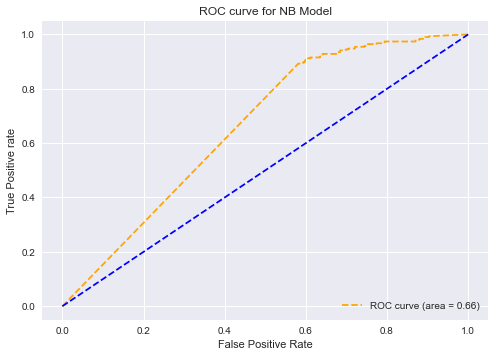

In [48]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)
JOENB=GaussianNB()
JOENB.fit(X_train, y_train)


metricsshow(JOENB)
showroc(model=JOENB,title='ROC curve for NB Model')

### Testing on external data

#### Preparing ext_test data

In [31]:
l=[]
for i in Datum.Label:
    if i =='Active':
        l.append(1)
    else:
        l.append(0)
Datum=Datum.drop('Label',axis=1)
Datum['Label']=l
Datum = Datum.fillna(0)
#Manual Standardization
dt= pd.DataFrame()
for i in col:
    array = np.array(Datum[i])
    mean = dp[i][0]
    std = dp[i][1]
    aa=[]
    #print(aa)
    for j in array:
        
        n = ((j-mean)/std)
        aa.append(n)
        #print(aa)
        
    dt[i]=aa
dt['Label'] =l 
dt

,nAcid,ALogP,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nC,...,AMW,WTPT-1,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Label
0,-0.300625,-0.137542,0.089259,0.028420,0.014137,0.144173,0.011229,-0.078300,0.086583,0.237697,...,-0.291446,0.060156,-0.568227,-0.663154,0.255624,-0.028038,0.671949,0.035869,0.346285,1
1,1.706171,-2.533393,0.698721,-0.254942,-1.594864,-1.559464,0.120094,0.145133,0.086583,-0.735489,...,-0.031843,0.027369,1.649615,3.469275,-1.137795,-0.028038,0.296174,-3.008820,-0.009954,0
2,1.706171,-0.349262,-0.572652,-0.536848,0.371693,0.314537,-0.641961,-0.190017,-0.963288,-0.735489,...,0.565103,-0.230770,0.920278,0.803233,-0.075504,-0.028038,-0.294329,-0.943348,-0.168282,0
3,-0.300625,1.756507,-0.356302,-0.518611,-0.522197,-0.537282,-0.369798,-0.860317,0.086583,-0.457436,...,-0.554451,-0.923984,-1.335279,-0.677051,-1.137795,-0.028038,-0.884831,1.009319,-0.801595,1
4,-0.300625,0.976243,-1.335948,-1.209714,0.192915,0.314537,-1.295150,-1.195467,-1.249616,-1.013542,...,0.220070,-1.162059,-1.011194,-1.044961,-0.545910,-0.028039,-1.045878,-0.032968,-1.078669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,-0.300625,0.774439,-0.914775,-0.252224,1.444360,1.336719,-0.260933,0.256850,-0.676959,-0.179383,...,0.243672,0.247760,1.093074,-0.666748,1.844705,-0.028038,0.296174,-0.471579,0.306702,0
492,-0.300625,-0.757372,-0.029829,0.341798,0.550471,0.484901,0.392256,0.480283,0.277468,0.376724,...,-0.146995,0.448838,0.492991,0.998121,0.007665,-0.028036,-0.186964,-0.254256,0.187956,0
493,-0.300625,1.678511,0.885283,-0.507427,-1.594864,-1.559464,-0.914123,-0.413450,-1.249616,-0.735489,...,1.434754,-0.355138,0.319231,-0.600146,-1.137795,-0.028038,0.564585,-0.178932,0.346285,0
494,-0.300625,-0.046039,-0.419932,-1.128420,-1.594864,-1.559464,-0.859690,-1.530617,-0.199745,-1.291596,...,-0.781051,-1.588808,-1.349890,-1.044961,-0.677198,-0.028039,-1.582698,-0.220378,-1.632817,0


#### Algorithms on test data

In [35]:
Xt = dt.iloc[:,:-1]
yt = dt.iloc[:,-1]

y1_predtest = JOEDT.predict(Xt)
print(JOEDT)
#DT Classifier metrics
DTACC = metrics.accuracy_score(yt, y1_predtest)
print("Accuracy:",DTACC)
y1_predtest = JOESVM.predict(Xt)
print(JOESVM)
#DT Classifier metrics
DTACC = metrics.accuracy_score(yt, y1_predtest)
print("Accuracy:",DTACC)
y1_predtest = JOELR.predict(Xt)
print(JOELR)
#DT Classifier metrics
DTACC = metrics.accuracy_score(yt, y1_predtest)
print("Accuracy:",DTACC)
y1_predtest = JOEKN.predict(Xt)
print(JOEKN)
#DT Classifier metrics
DTACC = metrics.accuracy_score(yt, y1_predtest)
print("Accuracy:",DTACC)
y1_predtest = JOENB.predict(Xt)
print(JOENB)
#DT Classifier metrics
DTACC = metrics.accuracy_score(yt, y1_predtest)
print("Accuracy:",DTACC)

RandomForestClassifier(max_depth=8, n_estimators=120)
Accuracy: 0.8165322580645161
SVC(C=2, gamma=0.1)
Accuracy: 0.7258064516129032
LogisticRegression()
Accuracy: 0.7983870967741935
KNeighborsClassifier(n_neighbors=3)
Accuracy: 0.7600806451612904
GaussianNB()
Accuracy: 0.6431451612903226


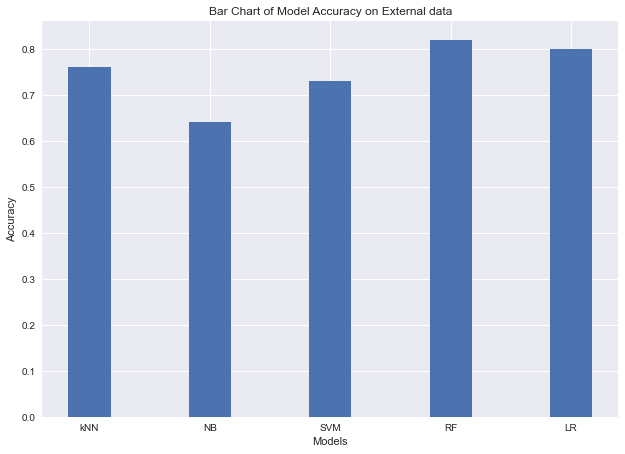

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['kNN','NB','SVM','RF', 'LR']
students = [0.76,0.64,0.73,0.82,0.80]
ax.bar(langs,students, width = 0.35)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Bar Chart of Model Accuracy on External data')
plt.show()

In [38]:
w=sa(title='Save Model as')
pickle.dump(JOEDT,open(w, 'wb'))

## EXTRAs

#### Descriptor Calculations with Padel

In [54]:
import glob
import subprocess

In [52]:
def desc_calc():
    # Performs the descriptor calculation
    bashCommand = "java -Xms2G -Xmx2G -Djava.awt.headless=true -jar ./Appfiles/PaDEL-Descriptor/PaDEL-Descriptor.jar -2d -removesalt -standardizenitro -descriptortypes ./Appfiles/PaDEL-Descriptor/ebov.xml -dir ./Appfiles -file ./Test.csv"
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

In [55]:
xml_files = glob.glob("\Appfiles\Descriptors.xml")
FP_list = ['Desc']
fp = dict(zip(FP_list, xml_files))
desc_calc()

#### Feature selection

##### Feature selection with rfe

In [23]:
TRA = Tra.iloc[:,:-1]
cart = DecisionTreeClassifier()

fs_x = np.array(TRA)
fs_y = np.array(Tra.iloc[:,-1])

rfe = RFE(estimator=cart, n_features_to_select=30, step=1)
rfe.fit(fs_x, fs_y)
select_features_rfe = rfe.get_support()
feature_names_rfe = TRA.columns[select_features_rfe]
print(feature_names_rfe)
feature_subset_df = TRA[feature_names_rfe]
print(feature_subset_df)
bc_cX = np.array(feature_subset_df)
bc_cX


Index(['AATS8v', 'AATS7p', 'AATS1i', 'AATS5i', 'ATSC0c', 'ATSC3c', 'ATSC2v',
       'ATSC7v', 'AATSC3m', 'AATSC4m', 'AATSC8m', 'GATS7c', 'GATS2e',
       'BCUTc-1l', 'BCUTp-1h', 'SpMax3_Bhs', 'SpMin8_Bhs', 'VC-3', 'Sv',
       'CrippenLogP', 'naaN', 'ndO', 'minsCH3', 'maxHBint2', 'maxsssN',
       'ZMIC2', 'nAtomP', 'MLFER_A', 'piPC10', 'XLogP'],
      dtype='object')
          AATS8v    AATS7p      AATS1i      AATS5i       ATSC0c    ATSC3c  \
0       0.000000  0.000000  116.174404    0.000000  1137.172819  0.000000   
1     107.727963  0.949723  145.726230  165.878307     0.360707 -0.068817   
2     188.320510  1.343984  148.861548  164.009899     1.136959 -0.258346   
3     103.585871  1.237403  146.263872  165.166075     0.486282 -0.144731   
4     187.284888  1.275880  150.838220  164.615842     1.612573  0.273368   
...          ...       ...         ...         ...          ...       ...   
1475  175.516280  1.319714  142.473754  157.072552     0.687466 -0.171236   
1476    0.000

array([[ 0.00000000e+00,  0.00000000e+00,  1.16174404e+02, ...,
         3.00000000e-03,  0.00000000e+00,  1.16100000e+00],
       [ 1.07727963e+02,  9.49723153e-01,  1.45726230e+02, ...,
         5.91000000e-01,  2.30258509e+00,  7.57000000e+00],
       [ 1.88320510e+02,  1.34398395e+00,  1.48861548e+02, ...,
         1.67200000e+00,  7.20735048e+00,  3.50200000e+00],
       ...,
       [ 1.53052573e+02,  1.11789194e+00,  1.50020739e+02, ...,
         7.72000000e-01,  8.08930033e+00,  6.03000000e-01],
       [ 1.22980342e+02,  9.88568318e-01,  1.50683949e+02, ...,
        -8.00000000e-03,  3.44601140e+00,  3.70200000e+00],
       [ 1.34008471e+02,  1.07782393e+00,  1.47826937e+02, ...,
         8.04000000e-01,  4.90434842e+00,  3.33300000e+00]])

##### Feature selection with rfe and classifier

In [66]:
#Loading sets of features that works best with padel
dp = pd.read_csv('metrics.csv')
dp.drop('metrics',axis=1,inplace=True)

Tra = pd.read_csv('Train.csv')
Tra = Tra[dp.columns]


l=[]
for i in Train_smi['Labels']:
    if i == 'Active':
        l.append(1)
    else:
        l.append(0)

col = dp.columns
df = pd.DataFrame()
for i in col:
    array = np.array(Tra[i])
    mean = dp[i][0]
    std = dp[i][1]
    aa=[]
    #print(aa)
    for j in array:
        n = ((j-mean)/std)
        aa.append(n)
        
        
    df[i]=aa
df['Label'] =l 
Tra=df



Tra['Label'] = l
TRA = Tra.iloc[:,:-1]
TRA=TRA.fillna(0)

#cart = DecisionTreeClassifier()

fs_x = np.array(TRA)
fs_y = np.array(Tra.iloc[:,-1])
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(fs_x,fs_y)
imscore= rfc.feature_importances_
imfeat = [(feature, score) for feature, score in zip(TRA.columns, imscore)]
scores=sorted(imfeat, key=lambda x: -x[1])[:610]
scores

C:\Users\joe1a\AppData\Local\Temp\ipykernel_13276\3794781816.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i]=aa
C:\Users\joe1a\AppData\Local\Temp\ipykernel_13276\3794781816.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i]=aa
C:\Users\joe1a\AppData\Local\Temp\ipykernel_13276\3794781816.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

[('maxaaCH', 0.01632282076982841),
 ('MDEC-22', 0.014915937462326391),
 ('CrippenLogP', 0.014296122824434513),
 ('minsssN', 0.012672258393637578),
 ('maxsssN', 0.01236232734531589),
 ('MDEO-11', 0.01225843079110881),
 ('AATSC1c', 0.010726392046413675),
 ('XLogP', 0.009899411067945252),
 ('MLogP', 0.009869761231024723),
 ('SsssN', 0.009771608525036128),
 ('GATS2c', 0.008495718383567849),
 ('CIC0', 0.008127333522013419),
 ('SaaCH', 0.007969345935758411),
 ('ATSC2e', 0.007773389944396614),
 ('ATS7i', 0.007693048499042563),
 ('BCUTc-1h', 0.007113087033924739),
 ('nHaaCH', 0.006293972860844771),
 ('GATS2e', 0.006166237859450466),
 ('SpMax1_Bhs', 0.005928514046971156),
 ('C2SP2', 0.005370976298810499),
 ('nBondsS', 0.005297213050848941),
 ('minssCH2', 0.005154531143155327),
 ('nBase', 0.005138497671713464),
 ('WTPT-4', 0.004761681710266422),
 ('ATS8i', 0.00472332421631503),
 ('AATSC0c', 0.0046956670803060575),
 ('SpMax2_Bhs', 0.0046899694403430454),
 ('TopoPSA', 0.00451885792993372),
 ('nC',

In [72]:
scored=sorted(imfeat, key=lambda x: -x[1])[:20]
scored

[('maxaaCH', 0.01632282076982841),
 ('MDEC-22', 0.014915937462326391),
 ('CrippenLogP', 0.014296122824434513),
 ('minsssN', 0.012672258393637578),
 ('maxsssN', 0.01236232734531589),
 ('MDEO-11', 0.01225843079110881),
 ('AATSC1c', 0.010726392046413675),
 ('XLogP', 0.009899411067945252),
 ('MLogP', 0.009869761231024723),
 ('SsssN', 0.009771608525036128),
 ('GATS2c', 0.008495718383567849),
 ('CIC0', 0.008127333522013419),
 ('SaaCH', 0.007969345935758411),
 ('ATSC2e', 0.007773389944396614),
 ('ATS7i', 0.007693048499042563),
 ('BCUTc-1h', 0.007113087033924739),
 ('nHaaCH', 0.006293972860844771),
 ('GATS2e', 0.006166237859450466),
 ('SpMax1_Bhs', 0.005928514046971156),
 ('C2SP2', 0.005370976298810499)]

In [73]:
desc = []
importance = []
for i in range(len(scored)):
    desc.append(scored[i][0])
    importance.append(round(scored[i][1],5))

descim = pd.DataFrame(desc, columns=['Descriptor Name'])
descim['Importance score'] = importance
descim.to_csv('Descriptor_scores.csv',index=False)
descim


,Descriptor Name,Importance score
0,maxaaCH,0.01632
1,MDEC-22,0.01492
2,CrippenLogP,0.01430
3,minsssN,0.01267
4,maxsssN,0.01236
5,MDEO-11,0.01226
6,AATSC1c,0.01073
7,XLogP,0.00990
8,MLogP,0.00987
9,SsssN,0.00977


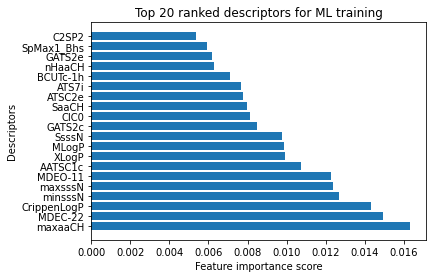

In [74]:
y = np.arange(len(desc))
plt.barh(y,importance)
plt.yticks(y,desc)
plt.xlabel('Feature importance score')
plt.ylabel('Descriptors')
plt.title('Top 20 ranked descriptors for ML training')
plt.show()

#### Applicability Domain Analysis

##### AD with William plot (Standard residual vrs leverage plot)

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [58]:
Tr = pd.read_csv('Train_smi.csv')
Te = pd.read_csv('Test_smi.csv')
dp = pd.read_csv('metrics.csv')
dp.drop('metrics',axis=1,inplace=True)
met = dp.columns


Tra = pd.read_csv('Train.csv')
Tes  = pd.read_csv('Test.csv')
Tra = Tra[met]
Tes = Tes[met]

#Tes['Label'] = Te['Labels']
#Tra['Label'] = Tr['Labels']

m=np.ones((Tra.shape[0],1))
n=np.zeros((Tes.shape[0],1))

q = np.concatenate((m,n),axis=0)
data = pd.concat([Tra,Tes])

lc = [];
for i in q:
    if i ==1:
        lc.append('Train')
    else:
        lc.append('Test')
data['Compounds']=lc


data=data.reset_index()
data.drop('index',axis=1,inplace=True)
data = data.sample(frac = 1)
data=data.reset_index()
data.drop('index',axis=1,inplace=True)


Y = data['WPATH']
#data.drop('Zagreb',axis=1,inplace=True)



lc = np.array(data.Compounds)

Datum = data.iloc[:,:-1]

Datum = Datum.fillna(0)
#Manual Standardization
dt= pd.DataFrame()
for i in met:
    array = np.array(Datum[i])
    mean = dp[i][0]
    std = dp[i][1]
    aa=[]
    #print(aa)
    for j in array:
        
        n = ((j-mean)/std)
        aa.append(n)
        #print(aa)
        
    dt[i]=aa
#dt['Label'] =l 

from sklearn.decomposition import PCA
dt.drop('WPATH',axis=1,inplace=True)

C:\Users\joe1a\AppData\Local\Temp\ipykernel_16728\3292325981.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dt[i]=aa
C:\Users\joe1a\AppData\Local\Temp\ipykernel_16728\3292325981.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dt[i]=aa
C:\Users\joe1a\AppData\Local\Temp\ipykernel_16728\3292325981.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

In [59]:
X=dt
y = pd.DataFrame(Y,columns=['Outcome'])

# generate OLS model

model = sm.OLS(Y, sm.add_constant(X))
model_fit = model.fit()


In [60]:
results = model.fit()
#print(results.summary())

# Get different Variables for diagnostic
residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag

residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag



In [51]:
#X['Zagreb']=Y
#X.to_csv('ADdata.csv',index=False)
X

,nAcid,ALogP,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nC,...,MW,AMW,WTPT-1,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,-0.300625,0.520557,0.938508,1.325276,0.550471,0.484901,1.263175,1.374016,1.041011,1.627964,...,1.145605,-0.191785,1.431007,0.134161,1.364153,-1.137795,-0.028035,1.477180,1.831039,194.0
1,-0.300625,0.039622,1.150983,0.782125,-0.522197,-0.537282,0.936580,0.703716,1.041011,0.654777,...,0.593610,-0.305383,0.693576,0.548966,0.945115,0.180928,-0.028037,0.886677,-0.639167,150.0
2,3.712967,0.006587,-0.917985,-1.804764,-1.594864,-1.559464,-1.621744,-1.642334,-1.440502,-1.847702,...,-1.600946,0.120586,-1.697168,-0.602149,0.341343,-1.137795,-0.028039,-1.636380,-1.517831,30.0
3,-0.300625,-1.012715,-0.265943,-0.396095,-0.522197,-0.537282,-0.315366,-0.413450,-0.199745,-0.318409,...,-0.503610,-0.247459,-0.415104,-0.396942,0.131033,-0.481428,-0.028038,-0.562739,-0.529604,92.0
4,1.706171,0.344914,-0.865314,-0.788443,0.371693,0.314537,-0.805258,-0.636884,-0.867845,-0.596463,...,-0.757004,-0.012916,-0.627608,-0.426326,-0.345089,0.095362,-0.028038,-0.938513,-0.223982,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,1.706171,0.951543,0.413808,-0.122938,-0.522197,-0.537282,-0.043204,0.033416,-0.104303,-0.040356,...,-0.051290,-0.112192,-0.013562,0.056665,1.256503,-1.137795,-0.028038,0.081446,-0.641690,116.0
1971,-0.300625,-0.845894,-0.492449,-1.217296,-1.594864,-1.559464,-0.968555,-1.307184,-0.581517,-1.569649,...,-1.301089,-0.443105,-1.372381,-0.229830,-1.044961,1.384378,-0.028039,-1.421652,-1.410791,42.0
1972,-0.300625,1.585549,0.770728,-0.218197,-0.522197,-0.537282,-0.859690,-0.301734,-1.249616,-0.874516,...,2.192580,3.297852,-0.396603,0.826906,0.376005,-0.041694,-0.028038,-0.025918,-0.639528,98.0
1973,-0.300625,-1.488113,0.744510,0.349055,-1.594864,-1.559464,0.664418,-0.078300,1.231896,0.098671,...,-0.096379,-0.545135,-0.179124,-0.451201,0.551024,-1.137795,-0.028037,-0.777467,0.764965,86.0


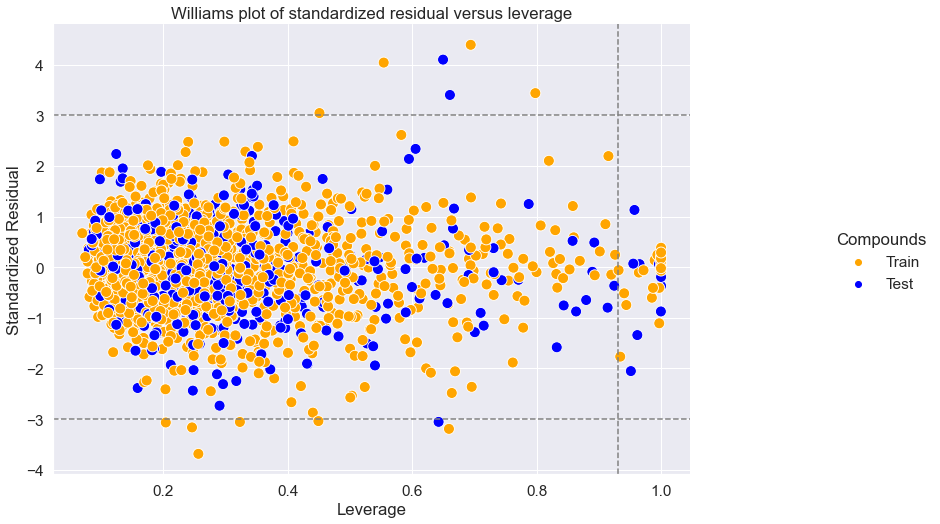

In [61]:
ad = pd.DataFrame(np.array(stand_resids),columns = ['Standardized Residual'])
ad['Leverage']=np.array(leverage)
ad['Compounds'] = lc
ad = ad.sample(frac = 1)
ad
#ad['Group'] = data['Group']
#ad = ad.sample(frac = 1)

sns.set(font_scale=1.4)
fg = sns.relplot(data=ad, x="Leverage", y="Standardized Residual", hue = "Compounds", kind="scatter",palette=['orange','blue'],s=120).set(title="Williams plot of standardized residual versus leverage")
fg.figure.set_size_inches(15,8)
fg.axes[0][0].axhline(y=3, ls='--', c='grey')
fg.axes[0][0].axhline(y=-3, ls='--', c='grey')
fg.axes[0][0].axvline(x=0.93, ls='--', c='grey')
#plt.savefig('save_as.png')

In [63]:
c=0
te=0
tr=0
for i in range(len(ad)):
    
    if ad['Standardized Residual'][i] > 3 or ad['Standardized Residual'][i] < -3 or ad['Leverage'][i] > 0.933:
        c+=1
        
        if ad['Compounds'][i]=='Train':
            tr+=1
        if ad['Compounds'][i]=='Test':
            te+=1
print('Outliers  :',c)
print('Train Compounds : ',tr)
print('Test Compounds  : ',te)

Outliers  : 50
Train Compounds :  36
Test Compounds  :  14


In [53]:
data

,nAcid,ALogP,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nC,...,AMW,WTPT-1,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Compounds
0,0,0.4348,77.6771,77.189376,12,12,67,35,32,29,...,7.107760,72.134125,16.459750,16.459750,0.000000,3920.0,63.0,8.582,194.0,Train
1,0,-0.3557,83.8734,66.267376,6,6,61,29,32,22,...,6.626740,58.548004,20.396558,13.596762,6.799796,2148.0,52.0,1.728,150.0,Test
2,2,-0.4100,23.5370,14.248758,0,0,14,8,6,4,...,8.430472,14.501921,9.471620,9.471620,0.000000,74.0,5.0,-0.710,30.0,Train
3,0,-2.0854,42.5522,42.575067,6,6,38,19,19,15,...,6.872013,38.122138,11.419180,8.034722,3.384458,826.0,25.0,2.032,92.0,Test
4,1,0.1461,25.0730,34.685516,11,11,29,17,12,13,...,7.865168,34.207060,11.140310,4.781721,6.358589,615.0,18.0,2.880,82.0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,1,1.1432,62.3755,48.067860,6,6,43,23,20,17,...,7.444790,45.519984,15.724251,15.724251,0.000000,1225.0,37.0,1.721,116.0,Test
1971,0,-1.8112,35.9467,26.061895,0,0,26,11,15,6,...,6.043567,20.485672,13.005204,0.000000,13.005204,192.0,9.0,-0.413,42.0,Train
1972,0,2.1853,72.7842,46.152344,6,6,28,20,8,11,...,21.884351,38.462997,23.034419,9.708440,5.651878,731.0,35.0,1.727,98.0,Test
1973,0,-2.8668,72.0196,57.558962,0,0,56,22,34,18,...,5.611531,42.469735,10.904223,10.904223,0.000000,1621.0,21.0,5.624,86.0,Test
